   ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0   1      20000    2          2         1   24      2      2     -1     -1   
1   2     120000    2          2         2   26     -1      2      0      0   
2   3      90000    2          2         2   34      0      0      0      0   
3   4      50000    2          2         1   37      0      0      0      0   
4   5      50000    1          2         1   57     -1      0     -1      0   

   ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  \
0  ...          0          0          0         0       689         0   
1  ...       3272       3455       3261         0      1000      1000   
2  ...      14331      14948      15549      1518      1500      1000   
3  ...      28314      28959      29547      2000      2019      1200   
4  ...      20940      19146      19131      2000     36681     10000   

   PAY_AMT4  PAY_AMT5  PAY_AMT6  default payment next month  
0         0         0   

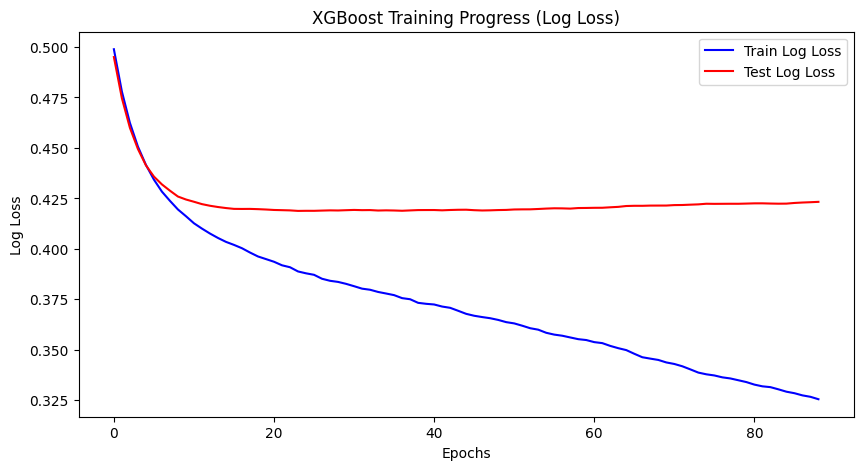

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import xgboost as xgb
from packaging import version
import sklearn
from sklearn.metrics import accuracy_score, classification_report

df = pd.read_excel("/home/jui/thesis-code/data/credit_card_clients.xls")

def split_label(dataset, target_feature):
    X = dataset.drop([target_feature], axis=1)
    y = dataset[[target_feature]]
    return X, y

# Handle different scikit-learn versions for OneHotEncoder parameters
if version.parse(sklearn.__version__) < version.parse('1.2'):
    ohe_params = {"sparse": False}
else:
    ohe_params = {"sparse_output": False}

def create_classification_pipeline(X):
    pipe_cfg = {
        'num_cols': X.dtypes[X.dtypes == 'int64'].index.values.tolist(),
        'cat_cols': X.dtypes[X.dtypes == 'object'].index.values.tolist(),
    }
    num_pipe = Pipeline([ 
        ('num_imputer', SimpleImputer(strategy='median')),
        ('num_scaler', StandardScaler())
    ])
    cat_pipe = Pipeline([
        ('cat_imputer', SimpleImputer(strategy='constant', fill_value='?')),
        ('cat_encoder', OneHotEncoder(handle_unknown='ignore', **ohe_params))
    ])
    feat_pipe = ColumnTransformer([
        ('num_pipe', num_pipe, pipe_cfg['num_cols']),
        ('cat_pipe', cat_pipe, pipe_cfg['cat_cols'])
    ])

    xgb_model = xgb.XGBClassifier(
        tree_method='hist',  # Fast histogram-based training
        random_state=10,
        n_jobs=-1,  # Use all CPU cores
        learning_rate=0.17,  # Controls step size
        reg_alpha=0.65,  # L1 regularization (sparsity)
        reg_lambda=1.0,  # L2 regularization (weight decay)
        eval_metric='logloss',  # Logarithmic loss for classification
        use_label_encoder=False,  # Avoids unnecessary warnings
        n_estimators=700,
        early_stopping_rounds=65
    )

    pipeline = Pipeline(steps=[('preprocessor', feat_pipe),
                               ('model', xgb_model)])

    return pipeline

target_feature = 'default payment next month'
categorical_features = []

# Split data into features and target
X, y = split_label(df, target_feature)

# Split data into train and test sets (80% training, 20% testing)
X_train_og, X_test_og, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=40)

features = X_train_og.columns.tolist()  # Extract feature names
classes = np.unique(y_train).tolist()  # Extract class labels

# Create the classification pipeline
pipeline = create_classification_pipeline(X_train_og)

# Fit the preprocessor separately to extract feature names
pipeline.named_steps['preprocessor'].fit(X_train_og)

# Extract transformed feature names safely
if hasattr(pipeline.named_steps['preprocessor'], "get_feature_names_out"):
    feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
else:
    # Manually construct feature names (for older sklearn versions)
    num_cols = X_train_og.select_dtypes(include=['int64', 'float64']).columns.tolist()
    cat_cols = X_train_og.select_dtypes(include=['object']).columns.tolist()
    feature_names = num_cols + cat_cols  # Not perfect, but works if get_feature_names_out() is missing

# Convert y_train and y_test to NumPy arrays
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

# Extract XGBClassifier separately and fit with eval_set
xgb_model = pipeline.named_steps['model']
model = xgb_model.fit(pipeline.named_steps['preprocessor'].transform(X_train_og), y_train, 
              eval_set=[(pipeline.named_steps['preprocessor'].transform(X_train_og), y_train),
                        (pipeline.named_steps['preprocessor'].transform(X_test_og), y_test)], verbose=False)

# Make predictions
y_pred = xgb_model.predict(pipeline.named_steps['preprocessor'].transform(X_test_og))

# Compute accuracy and classification report
accuracy = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Model Accuracy: {accuracy:.4f}")
print(f"Classification Report:\n{class_report}\n")

# Extract evaluation results
evals_result = xgb_model.evals_result()

# Get the final log loss for training and testing
train_log_loss = evals_result['validation_0']['logloss'][-1]
test_log_loss = evals_result['validation_1']['logloss'][-1]

# Print the final log loss values for both training and validation
print(f"Final Training Log Loss: {train_log_loss:.4f}")
print(f"Final Test Log Loss: {test_log_loss:.4f}")

# Plot training and validation log loss
plt.figure(figsize=(10, 5))
plt.plot(evals_result['validation_0']['logloss'], label='Train Log Loss', color='blue')
plt.plot(evals_result['validation_1']['logloss'], label='Test Log Loss', color='red')
plt.xlabel("Epochs")
plt.ylabel("Log Loss")
plt.title("XGBoost Training Progress (Log Loss)")
plt.legend()
plt.show()

In [8]:
from art.estimators.classification import XGBoostClassifier
from art.attacks.evasion import ZooAttack
from art.utils import load_mnist

import warnings
warnings.filterwarnings('ignore')

# Convert DataFrame to NumPy array for XGBoost
X_train_np = X_train_og.to_numpy()

# Ensure labels are in the correct shape
y_train_np = np.array(y_train).flatten()

# Assuming train_og_np and y_train_np are NumPy arrays
subset_indices = np.random.choice(X_train_np.shape[0], 7500, replace=False)

# Select random 7500 samples
X_train_subset = X_train_np[subset_indices]
y_train_subset = y_train[subset_indices]

def get_adversarial_examples(X_train_subset, y_train_subset, num_classes=2):
    # Define XGBoost parameters
    num_round = 10
    param = {'objective': 'multi:softprob', 'eval_metric': 'mlogloss', 'num_class': num_classes}

    # Train XGBoost model
    train_data = xgb.DMatrix(X_train_subset, label=y_train_subset)
    model = xgb.train(param, train_data, num_round)

    # Create ART classifier for XGBoost
    art_classifier = XGBoostClassifier(model=model, nb_features=X_train_subset.shape[1], nb_classes=num_classes)

    # Create ART Zeroth Order Optimization attack
    zoo = ZooAttack(classifier=art_classifier, confidence=0.0, targeted=False, learning_rate=1e-1, max_iter=20,
                    binary_search_steps=10, initial_const=1e-3, abort_early=True, use_resize=False, 
                    use_importance=False, nb_parallel=1, batch_size=1, variable_h=0.2)
    
    # Generate adversarial samples
    x_train_adv = zoo.generate(X_train_subset)

    return x_train_adv, model

In [9]:
x_train_adv, model = get_adversarial_examples(X_train_subset, y_train_subset, num_classes=2)

ZOO:   0%|          | 0/7500 [00:00<?, ?it/s]

ZOO: 100%|██████████| 7500/7500 [05:19<00:00, 23.50it/s]


Accuracy on Original Data: 81.20%
Accuracy on Adversarial Data: 79.28%


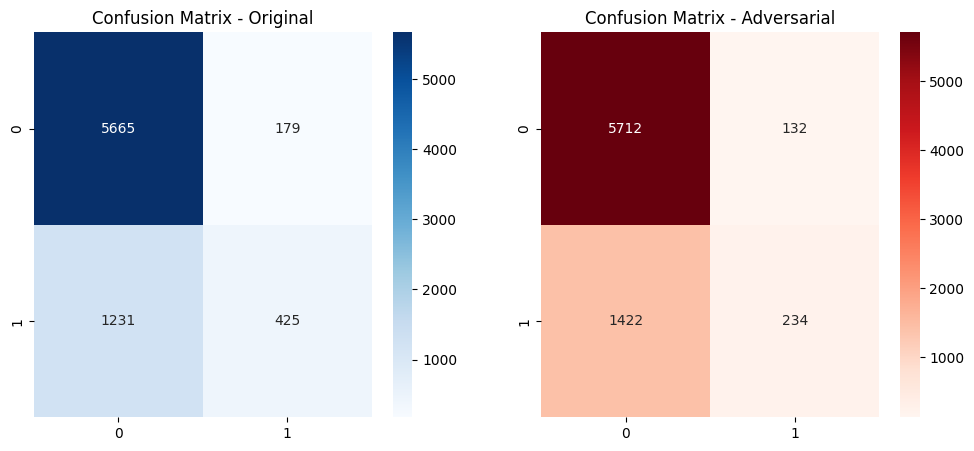

In [26]:
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Predictions on the original data
y_pred_og = model.predict(X_train_subset)  # Direct prediction on the original data

# Predictions on the adversarial data
y_pred_adv = model.predict(x_train_adv)    # Direct prediction on the adversarial data

# Compute accuracy
accuracy_og = accuracy_score(y_train_subset, y_pred_og)
accuracy_adv = accuracy_score(y_train_subset, y_pred_adv)

print(f"Accuracy on Original Data: {accuracy_og * 100:.2f}%")
print(f"Accuracy on Adversarial Data: {accuracy_adv * 100:.2f}%")

# Confusion Matrix for both original and adversarial data
cm_original = confusion_matrix(y_train_subset, y_pred_og)
cm_adv = confusion_matrix(y_train_subset, y_pred_adv)

# Plot Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cm_original, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title("Confusion Matrix - Original")

sns.heatmap(cm_adv, annot=True, fmt='d', cmap='Reds', ax=axes[1])
axes[1].set_title("Confusion Matrix - Adversarial")

plt.show()